In [1]:
import os

# Change the directory to the location which contains the python files and data (cif and csv)
root_directory = 'C:/Users/U S VAITESSWAR/Desktop/For training/Inverse design'
os.chdir(root_directory)

import argparse
import shutil
import sys
import time
import warnings
from random import sample

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR

from DataLoader import CIFData, collate_pool, get_train_val_test_loader
from DataLoader_inverse import Prediction, collate_pool_inv, get_train_val_test_loader_inv
from Model import CrystalGraphConvNet

In [2]:
class Normalizer(object):
    """Normalize a Tensor and restore it later. """

    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor,dim = 0)
        self.std = torch.std(tensor,dim = 0)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']
        
def validate(val_loader, model, normalizer_target, criterion, test = False):
    batch_time = AverageMeter()
    losses = AverageMeter()
    mae_errors = AverageMeter()
    
    if test:
        test_targets = []
        test_preds = []
        test_cif_ids = []

    # switch to evaluate mode
    model.eval()

    end = time.time()
        
    for i, (input, target, batch_cif_ids) in enumerate(val_loader):
        with torch.no_grad():
            
            input_var = (Variable(input[0]),
                         Variable(input[1]),
                         input[2],
                         input[3])

        target_normed = normalizer_target.norm(target)
        
        with torch.no_grad():
            target_var = Variable(target_normed)

        # compute output
        output = model(*input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        mae_error = mae(normalizer_target.denorm(output.data.cpu()), target)
        losses.update(loss.data.cpu().item(), target.size(0))
        mae_errors.update(mae_error, target.size(0))
        
        if test:
            test_pred = normalizer_target.denorm(output.data.cpu())
            test_target = target
            test_preds += test_pred.view(-1).tolist()
            test_targets += test_target.view(-1).tolist()
            test_cif_ids += batch_cif_ids
            
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
    
        if i % 10 == 0:
                print('Test: [{0}/{1}]\t' # print frequency = 10
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      mae_errors=mae_errors))
            
    if test:
        star_label = '**'
        import csv
        with open('test_results.csv', 'w') as f:
            writer = csv.writer(f)
            for cif_id, target, pred in zip(test_cif_ids, test_targets,
                                            test_preds):
                writer.writerow((cif_id, target, pred))
    else:
        star_label = '*'
    
    if test:
        print(' {star} MAE {mae_errors.avg:.3f}'.format(star=star_label,mae_errors=mae_errors))                                             
        return test_preds,test_targets,test_cif_ids
    else:
        return mae_errors.avg
    
def mae(prediction, target):
    """
    Computes the mean absolute error between prediction and target
    Parameters
    ----------
    prediction: torch.Tensor (N, 1)
    target: torch.Tensor (N, 1)
    """
    diff = prediction - target
    mae = torch.mean(abs(diff))
    return mae

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def adjust_learning_rate(optimizer, epoch, k):
    """Sets the learning rate to the initial LR decayed by 10 every k epochs"""
    assert type(k) is int
    lr = args.lr * (0.1 ** (epoch // k))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [3]:
def fermi_prediction(train_loader, model, normalizer_target):
    test_preds = []
    test_cif_ids = []

    # switch to evaluate mode
    model.eval()
        
    for i, (input, batch_cif_ids) in enumerate(train_loader):
        with torch.no_grad():
            input_var = (Variable(input[0]),
                         Variable(input[1]),
                         input[2],
                         input[3])
    
        # compute output
        output = model(*input_var)
        test_pred = normalizer_target.denorm(output.data.cpu())
        test_preds += test_pred.view(-1).tolist()
        test_cif_ids += batch_cif_ids  
                                           
    return test_preds,test_cif_ids

In [4]:
# Input the directory which contains the cif files
directory = 'C:/Users/U S VAITESSWAR/Desktop/For training/Inverse design/cifs_CGCNN_dataset_47k'
dataset = CIFData(directory)
collate_fn = collate_pool

train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset = dataset,
    collate_fn = collate_fn,
    batch_size = 32,
    train_ratio = 1,
    num_workers = 0, # All workers
    val_ratio = 0,
    test_ratio = 0,
    pin_memory = False,
    train_size = None,
    val_size = None,
    test_size = None,
    return_test = True)

#sample_data_list = [dataset[i] for i in sample(range(len(dataset)), 500)]
#sample_input, sample_target, _ = collate_pool(sample_data_list)

import pandas as pd

data = pd.read_excel('CGCNN_original_dataset_47k_augmented.xlsx')
data = data.iloc[:,5]
sample_target = torch.Tensor(list(data.values))
sample_target = sample_target.reshape([-1,1])
normalizer_target = Normalizer(sample_target)

structures, _, _ = dataset[0] # Extracting only the first element of the data set
criterion = nn.MSELoss()

C:\Users\U S VAITESSWAR\Anaconda3\lib\site-packages\pymatgen\io\cif.py:37: UserWarning: Please install optional dependency pybtex if youwant to extract references from CIF files.
  warnings.warn("Please install optional dependency pybtex if you"


In [5]:
# CGCNN model for predicting fermi energy
orig_atom_fea_len = structures[0].shape[-1] # Number of features in the atomic feature vector
nbr_fea_len = structures[1].shape[-1] # Number of features in the neighbor feature vector

model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len = 64, # First layer of linear transformation before convolution
                            n_conv = 4, # Number of convolution layers
                            h_fea_len = 32, # Number of hidden units
                            n_h = 1, # Number of hidden layers
                            classification = False) # Regression

print('---------Evaluate Model on Test Set---------------')
best_checkpoint = torch.load('efermi.pth.tar',map_location='cpu')
model.load_state_dict(best_checkpoint['state_dict'])
test, target, cif_ids = validate(train_loader, model, normalizer_target, criterion, test=True)

---------Evaluate Model on Test Set---------------
Test: [0/194]	Time 1.358 (1.358)	Loss 0.0158 (0.0158)	MAE 0.252 (0.252)
Test: [10/194]	Time 1.158 (1.346)	Loss 0.0296 (0.0259)	MAE 0.389 (0.335)
Test: [20/194]	Time 1.533 (1.388)	Loss 0.0169 (0.0280)	MAE 0.276 (0.335)
Test: [30/194]	Time 1.219 (1.415)	Loss 0.0179 (0.0298)	MAE 0.288 (0.343)
Test: [40/194]	Time 1.278 (1.417)	Loss 0.0255 (0.0292)	MAE 0.320 (0.340)


C:\Users\U S VAITESSWAR\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1106: UserWarning: Issues encountered while parsing CIF:
  warnings.warn("Issues encountered while parsing CIF:")
C:\Users\U S VAITESSWAR\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1108: UserWarning: Some fractional co-ordinates rounded to ideal values to avoid finite precision errors.
  warnings.warn(error)


Test: [50/194]	Time 0.995 (1.419)	Loss 0.0134 (0.0293)	MAE 0.254 (0.342)
Test: [60/194]	Time 1.256 (1.402)	Loss 0.0310 (0.0306)	MAE 0.341 (0.343)
Test: [70/194]	Time 0.955 (1.379)	Loss 0.0798 (0.0322)	MAE 0.389 (0.345)
Test: [80/194]	Time 1.061 (1.357)	Loss 0.0578 (0.0320)	MAE 0.423 (0.344)
Test: [90/194]	Time 1.235 (1.358)	Loss 0.0357 (0.0326)	MAE 0.360 (0.345)
Test: [100/194]	Time 1.080 (1.358)	Loss 0.0161 (0.0319)	MAE 0.265 (0.343)
Test: [110/194]	Time 1.187 (1.356)	Loss 0.0257 (0.0321)	MAE 0.320 (0.343)
Test: [120/194]	Time 1.186 (1.338)	Loss 0.0178 (0.0327)	MAE 0.300 (0.343)
Test: [130/194]	Time 1.520 (1.332)	Loss 0.0328 (0.0326)	MAE 0.353 (0.343)
Test: [140/194]	Time 1.156 (1.331)	Loss 0.0396 (0.0321)	MAE 0.416 (0.341)
Test: [150/194]	Time 1.118 (1.326)	Loss 0.0134 (0.0325)	MAE 0.254 (0.341)
Test: [160/194]	Time 0.987 (1.325)	Loss 0.0228 (0.0323)	MAE 0.335 (0.342)
Test: [170/194]	Time 1.187 (1.317)	Loss 0.0164 (0.0322)	MAE 0.261 (0.341)
Test: [180/194]	Time 1.118 (1.311)	Loss 0.0

In [10]:
import xlsxwriter

actual = np.array(target)
prediction = np.array(test)

workbook = xlsxwriter.Workbook('Fermi energy model performance.xlsx') 
worksheet = workbook.add_worksheet()
row = 0
col = 0

# Iterate over the data and write it out row by row
for i in range(len(actual)):
    worksheet.write(row, col, actual[i])
    worksheet.write(row, col + 1, prediction[i])


    row += 1

workbook.close()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_excel('hexagonal.xlsx')
X = dataset.iloc[:,1:29].values
y = dataset.iloc[:,29:30].values
doping = X[:,14]
indices_1 = np.where(doping == 1e20)
X1 = X[indices_1,:][0]
y1 = y[indices_1,:][0]
indices_2 = np.where(doping == 1e19)
X2 = X[indices_2,:][0]
y2 = y[indices_2,:][0]
indices_3 = np.where(doping == 1e18)
X3 = X[indices_3,:][0]
y3 = y[indices_3,:][0]
temperature = X3[:,13]
indices_4 = np.where(temperature < 1000)
X3 = X3[indices_4,:][0]
y3 = y3[indices_4,:][0]
X = np.vstack((X1,X2,X3))
y = np.vstack((y1,y2,y3))
indices_5 = np.where(y*(10**-21) >= 1) # Only power factor >= 1
y = y[indices_5,:][0]
X = X[indices_5,:][0]
y = np.log10(y)
y = y**6
X = X[:,[7,13,14,19,25,11]] # Mean electronegativity, temperature, doping, nsites, fermi energy, n/p (1 if n, 0 otherwise)

# Random Forest model for predicting power factor

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 391, 
                                  max_depth = 100, 
                                  min_samples_split = 2, 
                                  min_samples_leaf = 1,
                                  max_features = 'sqrt',
                                  bootstrap = False) # n_estimators refers to the number of trees needed
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test)

C:\Users\U S VAITESSWAR\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\U S VAITESSWAR\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\U S VAITESSWAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


<IPython.core.display.Javascript object>


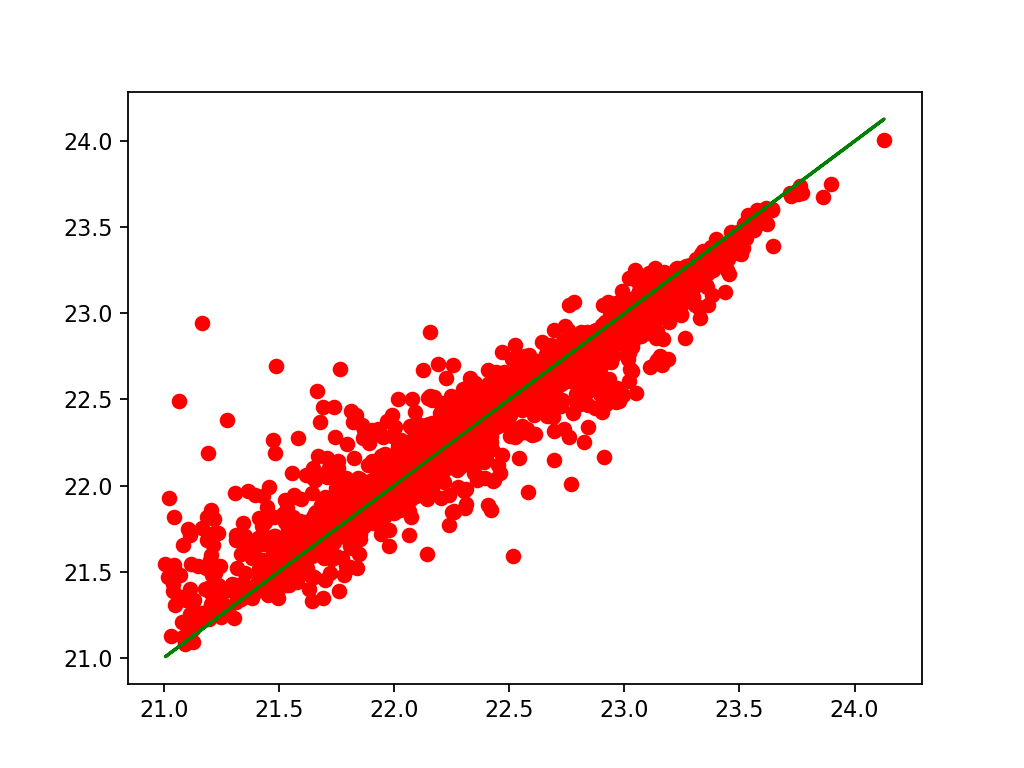

28.63561183268151 10.627137634693485


In [14]:
# Actual vs predicted power factor
transform_y_pred = y_pred**(1/6)
transform_y_pred_final = 10**transform_y_pred
transform_y_test = y_test**(1/6)
transform_y_test_final = 10**transform_y_test
transform_y_test_final = np.reshape(transform_y_test_final,[1,-1])
transform_y_pred_final = np.reshape(transform_y_pred_final,[1,-1])
errors = (abs(transform_y_test_final - transform_y_pred_final)/transform_y_test_final)*100
median_error = np.median((abs(transform_y_test_final - transform_y_pred_final)/transform_y_test_final)*100)
mean_error = np.mean((abs(transform_y_test_final - transform_y_pred_final)/transform_y_test_final)*100)

%matplotlib notebook
plt.scatter(transform_y_test,transform_y_pred, color = 'red')
plt.plot(transform_y_test, transform_y_test, 'green')
plt.show()

print(mean_error,median_error)

In [8]:
# New materials in MIT data set (outside training set for random forest)

crystal_structure = 'Hexagonal'

pos_materials_2 = pd.read_excel('CGCNN_original_dataset_47k_bandgap (with band gap).xlsx',crystal_structure)
pos_materials = pos_materials_2.iloc[:,[0,1,8,9]].values # cif_id, material, mean electronegativity, n sites
CIF = pos_materials_2.iloc[:,0].values

dataset_2 = Prediction(CIF,directory)
collate_fn = collate_pool_inv

train_loader, val_loader, test_loader = get_train_val_test_loader_inv(
    dataset = dataset_2,
    collate_fn = collate_fn,
    batch_size = 32,
    train_ratio = 1,
    num_workers = 0, # All workers
    val_ratio = 0,
    test_ratio = 0,
    pin_memory = False,
    train_size = None,
    val_size = None,
    test_size = None,
    return_test = True)

test, cif_ids = fermi_prediction(train_loader, model, normalizer_target)

fermi_sort = []

for i in range(len(pos_materials)):
    for j in range(len(test)):
        if pos_materials[i,0] == cif_ids[j]:
            fermi_sort.append(test[j])
            break

fermi_sort = np.array(fermi_sort)
fermi_sort = np.reshape(fermi_sort,[-1,1])
pos_materials = np.hstack((pos_materials,fermi_sort))

C:\Users\U S VAITESSWAR\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1106: UserWarning: Issues encountered while parsing CIF:
  warnings.warn("Issues encountered while parsing CIF:")
C:\Users\U S VAITESSWAR\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1108: UserWarning: Some fractional co-ordinates rounded to ideal values to avoid finite precision errors.
  warnings.warn(error)


<IPython.core.display.Javascript object>


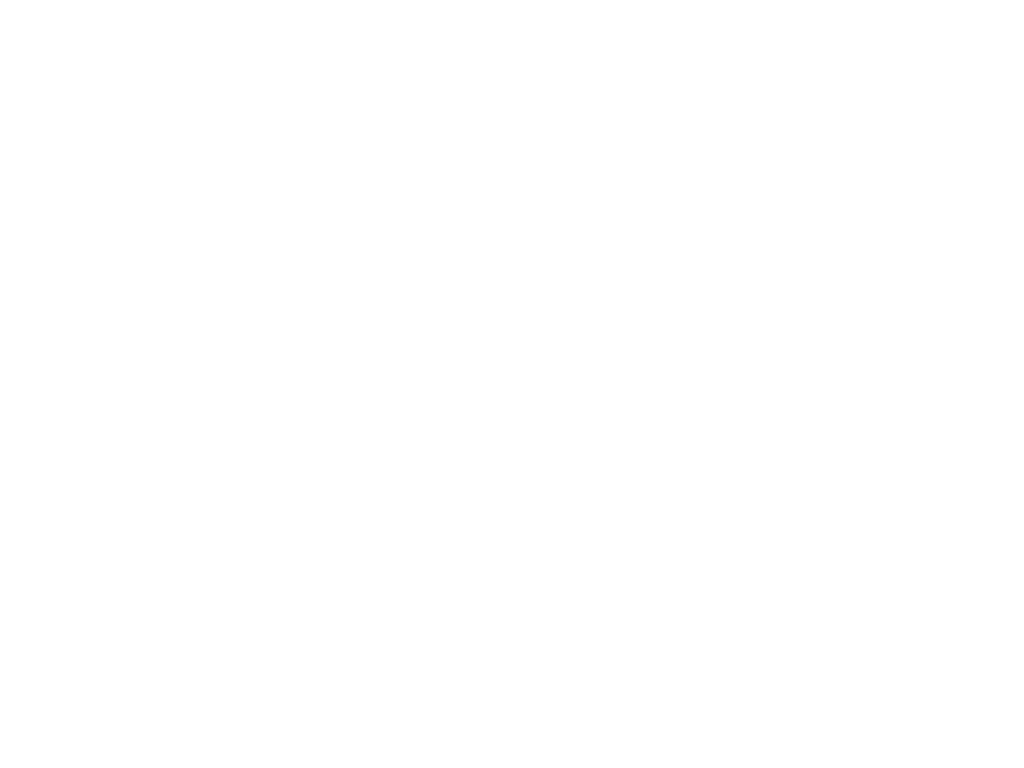

nan


In [9]:
%matplotlib notebook
target = pos_materials_2.iloc[:,5:6].values
plt.scatter(target,fermi_sort, color = 'red')
plt.plot(target, target, 'green')
plt.xlabel('Actual (fermi energy)')
plt.ylabel('Prediction (fermi energy)')
plt.show()

fraction = np.array(target) - (np.array(test))
print(np.mean(abs(fraction)))

In [18]:
import xlsxwriter

filename = crystal_structure + ' predictions.xlsx'
workbook = xlsxwriter.Workbook(filename) # Save the new materials for a given target power factor

combination = [(300,1e20,1),
               (300,1e19,1),
               (300,1e18,1),
               (500,1e20,1),
               (500,1e19,1),
               (500,1e18,1),
               (300,1e20,0),
               (300,1e19,0),
               (300,1e18,0),
               (500,1e20,0),
               (500,1e19,0),
               (500,1e18,0)]

target_pf_comb = [22.85,22.73,22.23,23.2,22.91,22.29,23.35,22.81,22.11,23.52,22.9,21.92]
category = ['A','B','C','D','E','F','G','H','I','J','K','L']

for z in range(6,7):
        
    # Temperature, doping and n/p can be user-defined.
    temperature = combination[z][0]
    doping = combination[z][1]
    n_or_p = combination[z][2]

    # Create all possible combinations of mean electronegativity, temperature, doping, nsites, fermi energy, n/p (1 if n, 0 otherwise)
    min_electro = min(X[:,0])
    max_electro = max(X[:,0])
    electro_array = np.arange(min_electro, max_electro, 0.1)
    min_nsites = min(X[:,3])
    max_nsites = max(X[:,3])
    nsites_array = np.arange(min_nsites, max_nsites, 1)
    min_fermi = min(X[:,4])
    max_fermi = max(X[:,4])
    fermi_array = np.arange(min_fermi, max_fermi, 0.1)
    all_comb = np.array(np.meshgrid(list(electro_array), [temperature], [doping], [list(nsites_array)], list(fermi_array), [n_or_p])).T.reshape(-1,6)
    all_comb_pred = regressor.predict(all_comb)
    
    print(str(z) + '1')
    
    # Find combinations which give a target power factor
    x = all_comb_pred ** (1/6)
    target_pf = target_pf_comb[z]
    y = np.where(x >= target_pf)
    indices = y[0]
    pos_values = all_comb[indices,:]
    good_val = pos_values[:,[0,3,4]]
    print(len(good_val))
        
    # Possible new materials with target properties after filtering 
    new_materials = list()

    for i,j,k,l,m in pos_materials:
        for n,o,p in good_val:
            if abs(n-k) <= 0.1:
                if abs(o-l) <= 1:
                    if abs(p-m) <= 0.1:
                        if i not in new_materials:
                            new_materials.append(i)
    
    print(str(z) + '2')
    # Save the possible materials in an excel file
    pred_pf = list()
    mat = list()
    chemical_struc = list()

    for i in new_materials:
        for j,k,l,m,n in pos_materials:
            if i == j:
                value = [float(l),float(temperature),float(doping),float(m),float(n),float(n_or_p)]
                mat.append(j)
                chemical_struc.append(k)
                pred_pf.append(value)
                
    if len(pred_pf) > 0:
        mat = np.array(mat)
        mat = np.reshape(mat,[-1,1])
        chemical_struc = np.array(chemical_struc)
        chemical_struc = np.reshape(chemical_struc,[-1,1])
        predictions = (regressor.predict(pred_pf))**(1/6)
        predictions = np.reshape(predictions,[-1,1])
        predictions = np.hstack((mat,chemical_struc,predictions))

        name = category[z]
        worksheet = workbook.add_worksheet(name)
        row = 0
        col = 0

        # Iterate over the data and write it out row by row
        for i,j,k in predictions:
            worksheet.write(row, col, i)
            worksheet.write(row, col + 1, j)
            worksheet.write(row, col + 2, k)
            row += 1

        print(str(z) + '3')
    
workbook.close()

61
1
62


In [21]:
all_materials = pos_materials_2.iloc[:,0].values
counts = np.zeros([len(all_materials),12])
category = ['A','B','C','D','E','F','G','H','I','J','K','L']

for i in range(12):
    filename = crystal_structure + ' predictions.xlsx'
    sheetname = category[i]
    predictions = pd.read_excel(filename,sheetname)
    if len(predictions) > 0:
        predictions = predictions.iloc[:,0].values
        for j in range(len(all_materials)):
            for k in range(len(predictions)):
                if all_materials[j] == predictions[k]:
                    counts[j,i] += 1
                    break

In [22]:
all_materials = np.reshape(all_materials,[-1,1])
freq_table = np.hstack((all_materials,counts))
names = ['Material','A','B','C','D','E','F','G','H','I','J','K','L']

## convert your array into a dataframe
df = pd.DataFrame (freq_table, columns= names)

## save to xlsx file

filepath = 'Frequency table.xlsx'

df.to_excel(filepath, index=False)

In [23]:
df

,Material,A,B,C,D,E,F,G,H,I,J,K,L
0,mp-30167,0,0,0,0,0,0,0,0,0,0,0,0
1,mp-760509,0,0,0,0,0,0,0,0,0,0,0,0
2,mp-570050,1,1,0,1,1,0,0,0,1,0,0,1
3,mp-11610,1,1,0,1,0,0,0,0,0,0,0,0
4,mp-978009,0,0,1,1,0,1,0,0,0,0,0,1
5,mp-972257,1,0,1,1,0,0,0,0,0,0,0,0
6,mp-2057,1,1,1,1,1,1,0,0,1,0,0,1
7,mp-4107,1,1,0,1,0,0,0,0,0,0,0,0
8,mp-555465,1,0,0,0,0,0,0,0,0,0,0,0
9,mp-8884,0,0,0,0,0,0,0,0,1,0,0,1
